In [133]:
#!/usr/bin/env python3
import tensorflow as tf

import os
import json

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator,FixedLocator
import numpy as np

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


import scipy.stats as stats
from scipy import stats
from scipy.special import inv_boxcox

from src.ForecastModel.data.models import DataModelCV
from src.ForecastModel.utils.postprocessing import ModelHandler

plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 6,
})


In [2]:
#plt.rcParams.update({
 #       'font.family' : 'Times New Roman',
  #      'axes.titlesize' : 22,
   #     'axes.labelsize' : 22,
    #    'xtick.labelsize' : 20,
     #   'ytick.labelsize' : 20})

#labelsize = 22
#legendsize = 20
#test_size = 22
#titlesize = 24
#textsize = 18

In [26]:


def bootstrap_acf_random(series, n_lags, n_bootstrap=10000, sample_size = 1000):
    acf_vals = []
    pacf_vals = []
    
    lower_acf_all = []
    higher_acf_all = []
    lower_pacf_all = []
    higher_pacf_all = []
    
    chunk_size = 10000
    chuncks = [series[i:i + chunk_size] for i in range(0, len(series), chunk_size)]
    print(len(chuncks[0]))
    
    for _ in range(n_bootstrap):
        random_int = np.random.randint(1,len(series)-sample_size)
        resampled_series = series[random_int:random_int+sample_size]
        acf_values, conf_acf = acf(resampled_series, nlags=n_lags, fft=True, alpha = 0.05)
        pacf_values, conf_pacf = pacf(resampled_series, nlags=n_lags, alpha = 0.05)
        
        lower_acf = conf_acf[:,0] - acf_values
        higher_acf = conf_acf[:,1] - acf_values
        
        lower_pacf = conf_pacf[:,0] - pacf_values
        higher_pacf = conf_pacf[:,1] - pacf_values
        
        acf_vals.append(acf_values)
        pacf_vals.append(pacf_values)
        lower_acf_all.append(lower_acf)
        higher_acf_all.append(higher_acf)
        lower_pacf_all.append(lower_pacf)
        higher_pacf_all.append(higher_pacf)        
        

    acf_vals = np.array(acf_vals)
    pacf_vals = np.asarray(pacf_vals)
    lower_acf_all = np.asarray(lower_acf_all)
    higher_acf_all = np.asarray(higher_acf_all)
    lower_pacf_all = np.asarray(lower_pacf_all)
    higher_pacf_all = np.asarray(higher_pacf_all)

    stacked_array = np.stack(acf_vals)
    acf_vals = np.mean(stacked_array, axis=0)
    stacked_array = np.stack(pacf_vals)
    pacf_vals = np.mean(stacked_array, axis=0)    

    stacked_array = np.stack(lower_acf_all)
    lower_acf_all = np.mean(stacked_array, axis=0)
    stacked_array = np.stack(higher_acf_all)
    higher_acf_all = np.mean(stacked_array, axis=0)

    stacked_array = np.stack(lower_pacf_all)
    lower_pacf_all = np.mean(stacked_array, axis=0)
    stacked_array = np.stack(higher_pacf_all)
    higher_pacf_all = np.mean(stacked_array, axis=0)   

    return acf_vals, pacf_vals, lower_acf_all, higher_acf_all, lower_pacf_all, higher_pacf_all

def bootstrap_acf(series, n_lags, n_bootstrap=10000, sample_size = 1000):
    acf_vals = []
    pacf_vals = []
    
    lower_acf_all = []
    higher_acf_all = []
    lower_pacf_all = []
    higher_pacf_all = []
    
    chuncks = [series[i:i + sample_size] for i in range(0, len(series), sample_size)]
    
    for chunck in chuncks:
        acf_values, conf_acf = acf(chunck, nlags=n_lags, fft=True, alpha = 0.05)
        pacf_values, conf_pacf = pacf(chunck, nlags=n_lags, alpha = 0.05)
        
        lower_acf = conf_acf[:,0] - acf_values
        higher_acf = conf_acf[:,1] - acf_values
        
        lower_pacf = conf_pacf[:,0] - pacf_values
        higher_pacf = conf_pacf[:,1] - pacf_values
        
        acf_vals.append(acf_values)
        pacf_vals.append(pacf_values)
        lower_acf_all.append(lower_acf)
        higher_acf_all.append(higher_acf)
        lower_pacf_all.append(lower_pacf)
        higher_pacf_all.append(higher_pacf)        
        
    acf_vals = np.array(acf_vals)
    pacf_vals = np.asarray(pacf_vals)
    lower_acf_all = np.asarray(lower_acf_all)
    higher_acf_all = np.asarray(higher_acf_all)
    lower_pacf_all = np.asarray(lower_pacf_all)
    higher_pacf_all = np.asarray(higher_pacf_all)

    stacked_array = np.stack(acf_vals)
    acf_vals = np.mean(stacked_array, axis=0)
    stacked_array = np.stack(pacf_vals)
    pacf_vals = np.mean(stacked_array, axis=0)    

    stacked_array = np.stack(lower_acf_all)
    lower_acf_all = np.mean(stacked_array, axis=0)
    stacked_array = np.stack(higher_acf_all)
    higher_acf_all = np.mean(stacked_array, axis=0)

    stacked_array = np.stack(lower_pacf_all)
    lower_pacf_all = np.mean(stacked_array, axis=0)
    stacked_array = np.stack(higher_pacf_all)
    higher_pacf_all = np.mean(stacked_array, axis=0)   

    return acf_vals, pacf_vals, lower_acf_all, higher_acf_all, lower_pacf_all, higher_pacf_all

In [134]:
PLOT_PATH          = r"plots"
DATA_PATH          = r"src\data\Dataset.csv"
CROSS_INDICES_PATH = r"src\data\indices"

In [135]:
models = {
    "arima": ModelHandler("ARIMA",
                r"rst\ARIMA",
                is_final_model = True,
                is_external_model = True,
                color = "#ff7f00",
                ls = "--",
                  ),
     "elstm": ModelHandler("eLSTM",
                   r"rst\eLSTM",
                   is_final_model = True,
                   color = '#984ea3',
                   ls = "-",
                 ),
     "pbhm-hlstm": ModelHandler("PBHM-HLSTM",
               r"rst\PBHM-HLSTM",
               is_final_model = True,
               color = "#e41a1c",
               ls = "-",
              )
     }

arima
2013
2014
2015
2016
2017


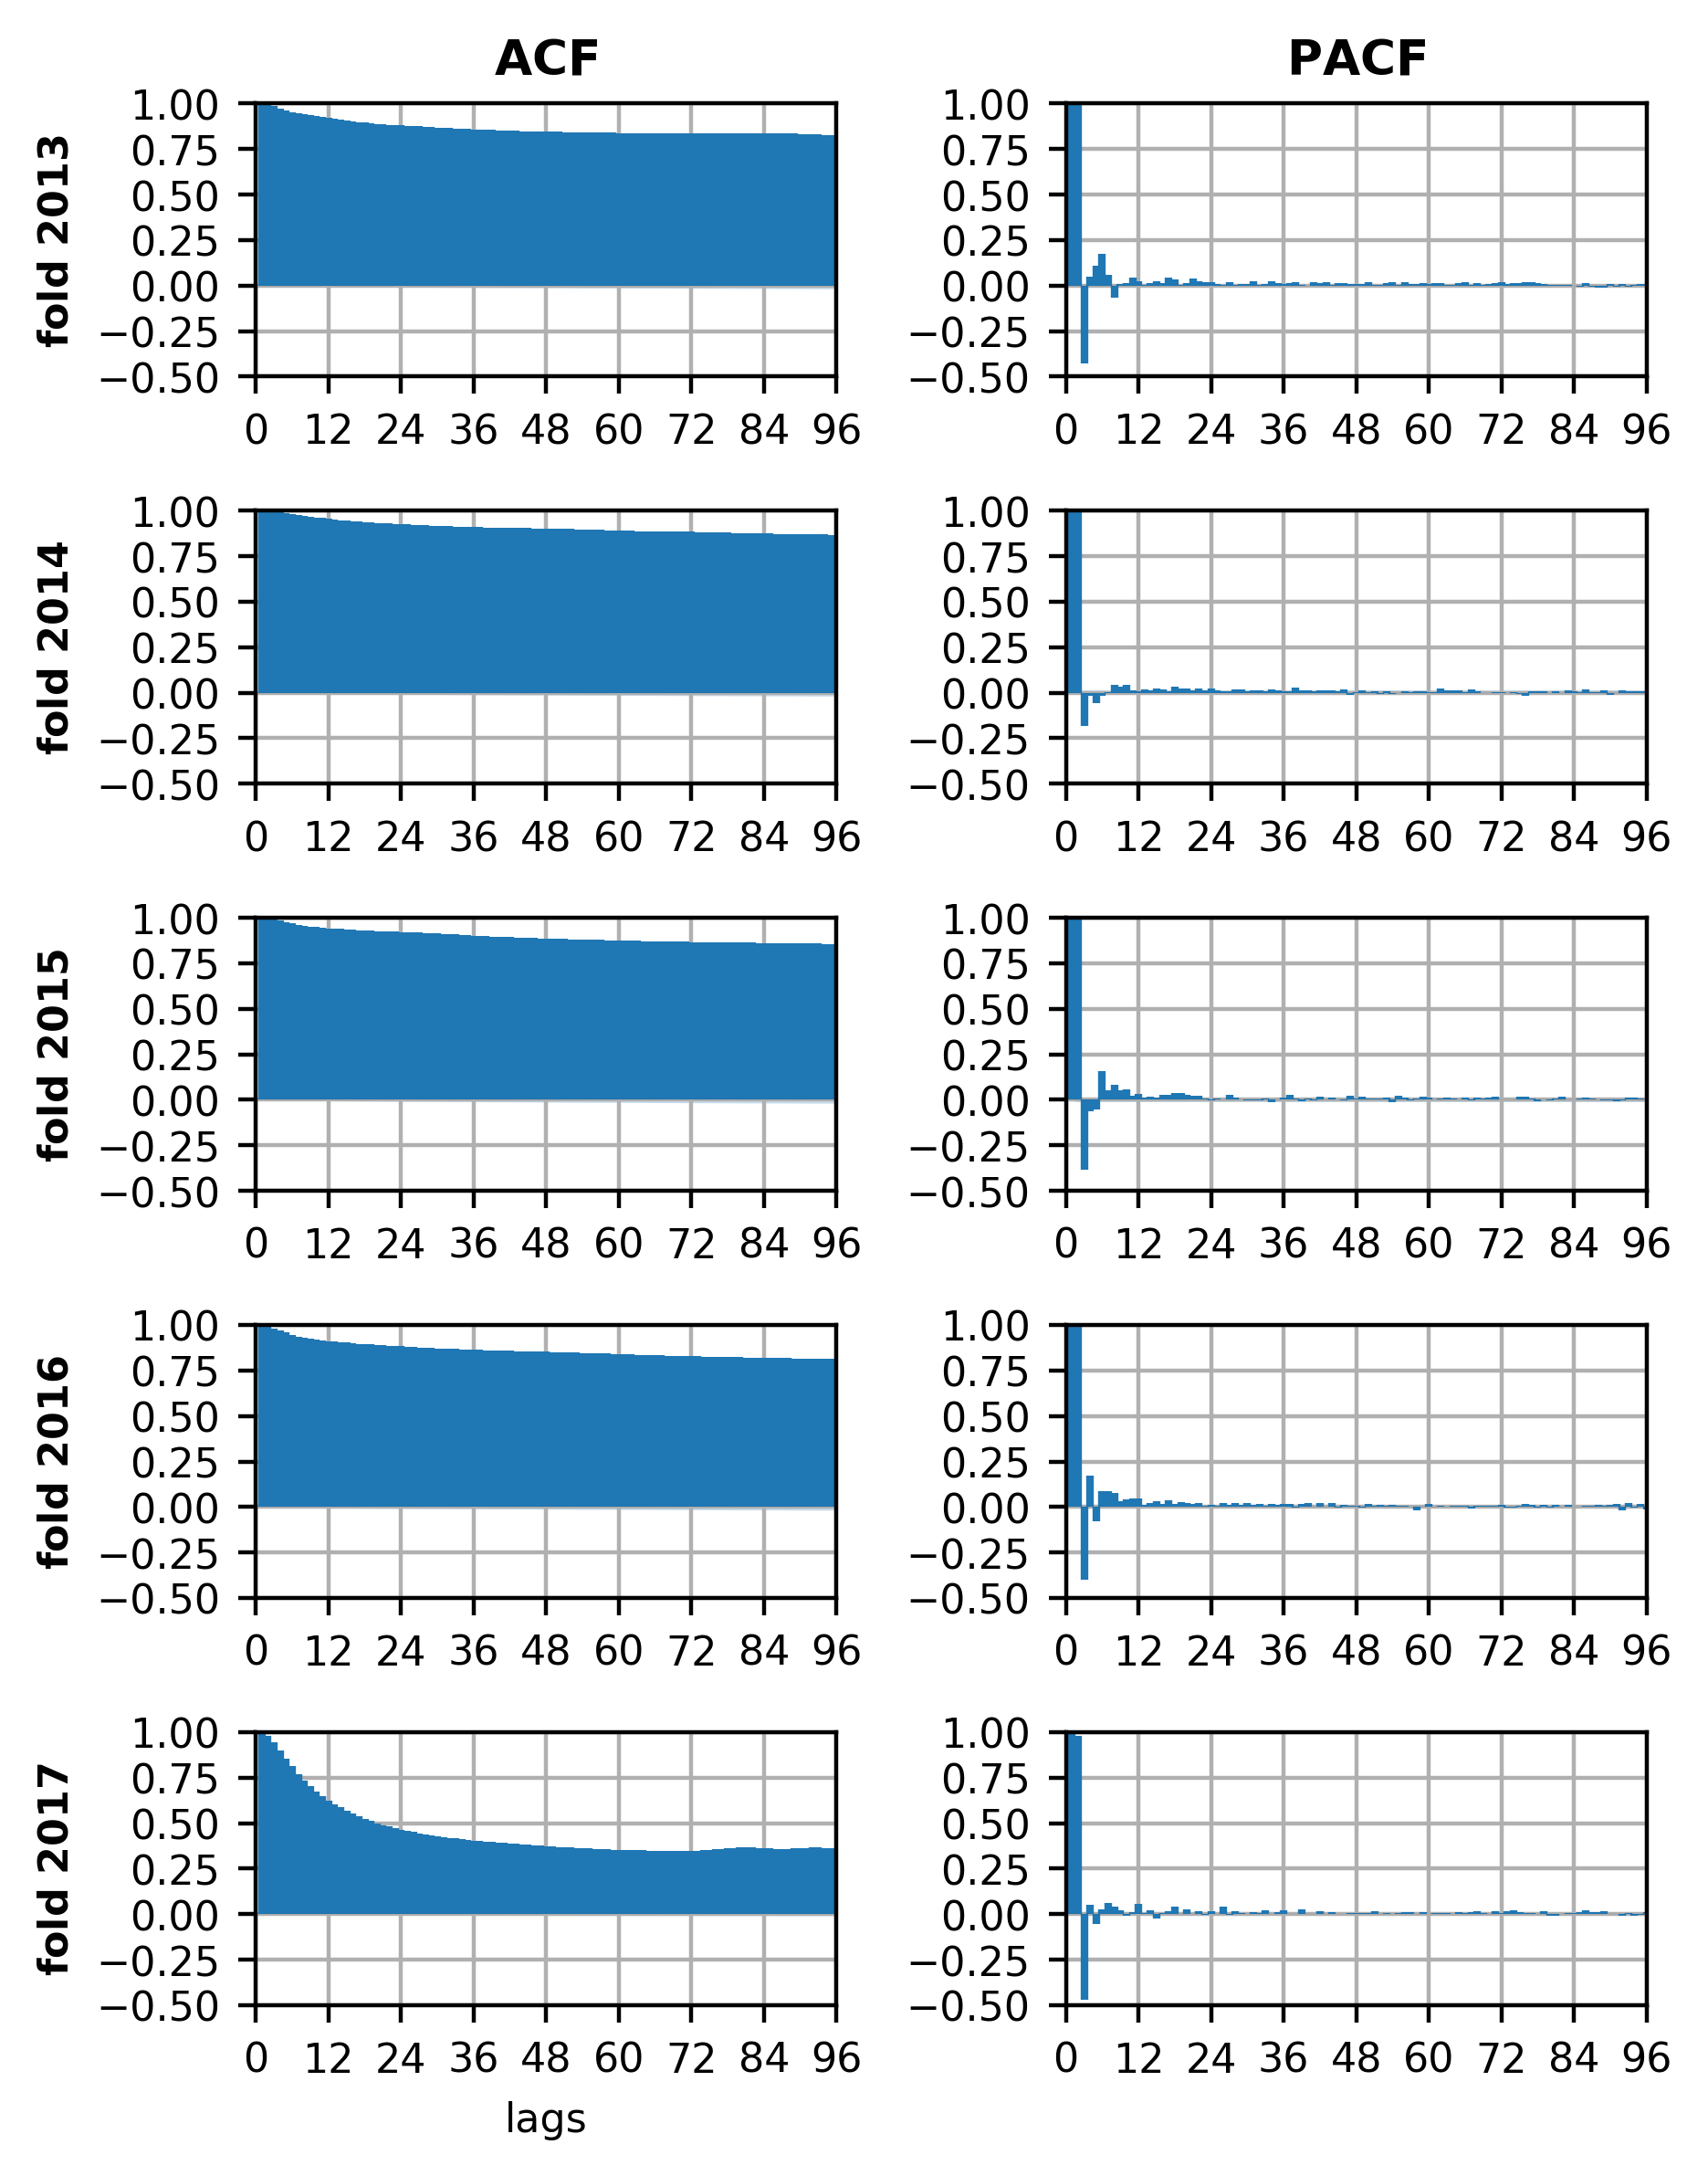

In [47]:
n_lags = 96

for n, key in enumerate(models.keys()):
    print(key)
    fig, axes = plt.subplots(5,2,figsize=(4.72,6), dpi=400)

    if models[key].is_external_model:
        overlap_length = 0
        hindcast_length = 96
    else:
        # load datamodel
        dm = DataModelCV(DATA_PATH,
           target_name       = models[key].target_name,
           hincast_features  = models[key].feat_hindcast,
           forecast_features = models[key].feat_forecast,
         )
        
        # load trial data
        with open(os.path.join(models[key].hp_path, "trial.json")) as f:
            trial = json.load(f)

        hindcast_length = trial['hyperparameters']['values']['hindcast_length']
        try:
            overlap_length = trial['hyperparameters']['values']['osc_length']
        except:
            overlap_length = 0 
        
        dm.main(os.path.join(CROSS_INDICES_PATH, f"cross_indices_{hindcast_length}.pkl"))

    for n_fold in range(5):
        year = 2013 + n_fold
        print(year)
        if models[key].is_external_model:
            # load external which come already with observations
            ext_df = pd.read_pickle(os.path.join(models[key].hp_path, f"forecast_{year}.pkl"))

            # get external model observations
            y = np.expand_dims(ext_df.filter(like="obs").values, axis=2) # fix 

            # get external model predictions
            yp = ext_df.filter(like="fc").values
                        
        else:
            # load dataset
            X, y  = dm.getDataSet(dm.cross_sets[n_fold]["test"], scale=True) 

           # if os.path.exists(os.path.join(models[key].hp_path, f"forecast_{year}.pkl")):
              #  yp = pd.read_pickle(os.path.join(models[key].hp_path, f"forecast_{year}.pkl")).values
           # else:
            # load model
            tf.keras.backend.clear_session()
            model  = tf.keras.models.load_model(os.path.join(models[key].hp_path, f"model_fold_{n_fold:d}.keras"))                          

            # model prediction
            yp = model.predict(X, batch_size=1000)

        # check for normal distribution 
        res = y[:,:,0]
        n_leadtime = 0
        plot_acf(res[:,n_leadtime],  lags=n_lags, bartlett_confint=True,
                ax = axes[n_fold, 0], title="", linewidth=0.01, markersize=0, alpha=0.75, color=models[key].color)
        #plot_acf(res[:,95],  lags=n_lags, bartlett_confint=True,
              #  ax = axes[n_fold, 1], title="", linewidth=0.01, markersize=0, alpha=0.75, color=models[key].color)
        plot_pacf(res[:,n_leadtime], lags=n_lags,
                ax = axes[n_fold, 1], title="", method="ywadjusted", linewidth=0.01, markersize=0, color=models[key].color)

        axes[n_fold, 0].set_xlim((-1,95))
        axes[n_fold, 1].set_xlim((-1,95))
        axes[n_fold, 0].set_ylim((-0.5,1))
        axes[n_fold, 1].set_ylim((-0.5,1))
        axes[n_fold, 0].grid()
        axes[n_fold, 1].grid()
        axes[n_fold, 0].set_ylabel(r"$\bf{"+f"fold\ {2013 + n_fold}"+r"}$")
        
        axes[n_fold, 0].xaxis.set_major_locator(FixedLocator(np.arange(-1,97,12)))
        axes[n_fold, 1].xaxis.set_major_locator(FixedLocator(np.arange(-1,97,12)))
        axes[n_fold, 0].yaxis.set_major_locator(FixedLocator(np.arange(-0.5,1.1,0.25)))
        axes[n_fold, 1].yaxis.set_major_locator(FixedLocator(np.arange(-0.5,1.1,0.25)))

        axes[n_fold, 0].set_xticklabels([f"{x+1:d}" for x in axes[n_fold, 0].get_xticks()])
        axes[n_fold, 1].set_xticklabels([f"{x+1:d}" for x in axes[n_fold, 1].get_xticks()])

        if n_fold == 0:
            axes[n_fold, 0].set_title(r"$\bf{ACF}$")
            axes[n_fold, 1].set_title(r"$\bf{PACF}$")
            #axes[n_fold, 0].set_title(r"$\bf{ACF(1)}$")
            #axes[n_fold, 1].set_title(r"$\bf{ACF(96)}$")
        if n_fold == 4:
            axes[n_fold, 0].set_xlabel("lags")
        
    fig.tight_layout()
    plt.show()
    plt.pause(0.001)
    fig.savefig(os.path.join(PLOT_PATH, f'ACF_PACF-{key}-comp-0-95-y.png'), dpi=300, bbox_inches='tight')
    break

arima
2017
elstm
dictonary loaded
2017
pbhm-hlstm
dictonary loaded
2017


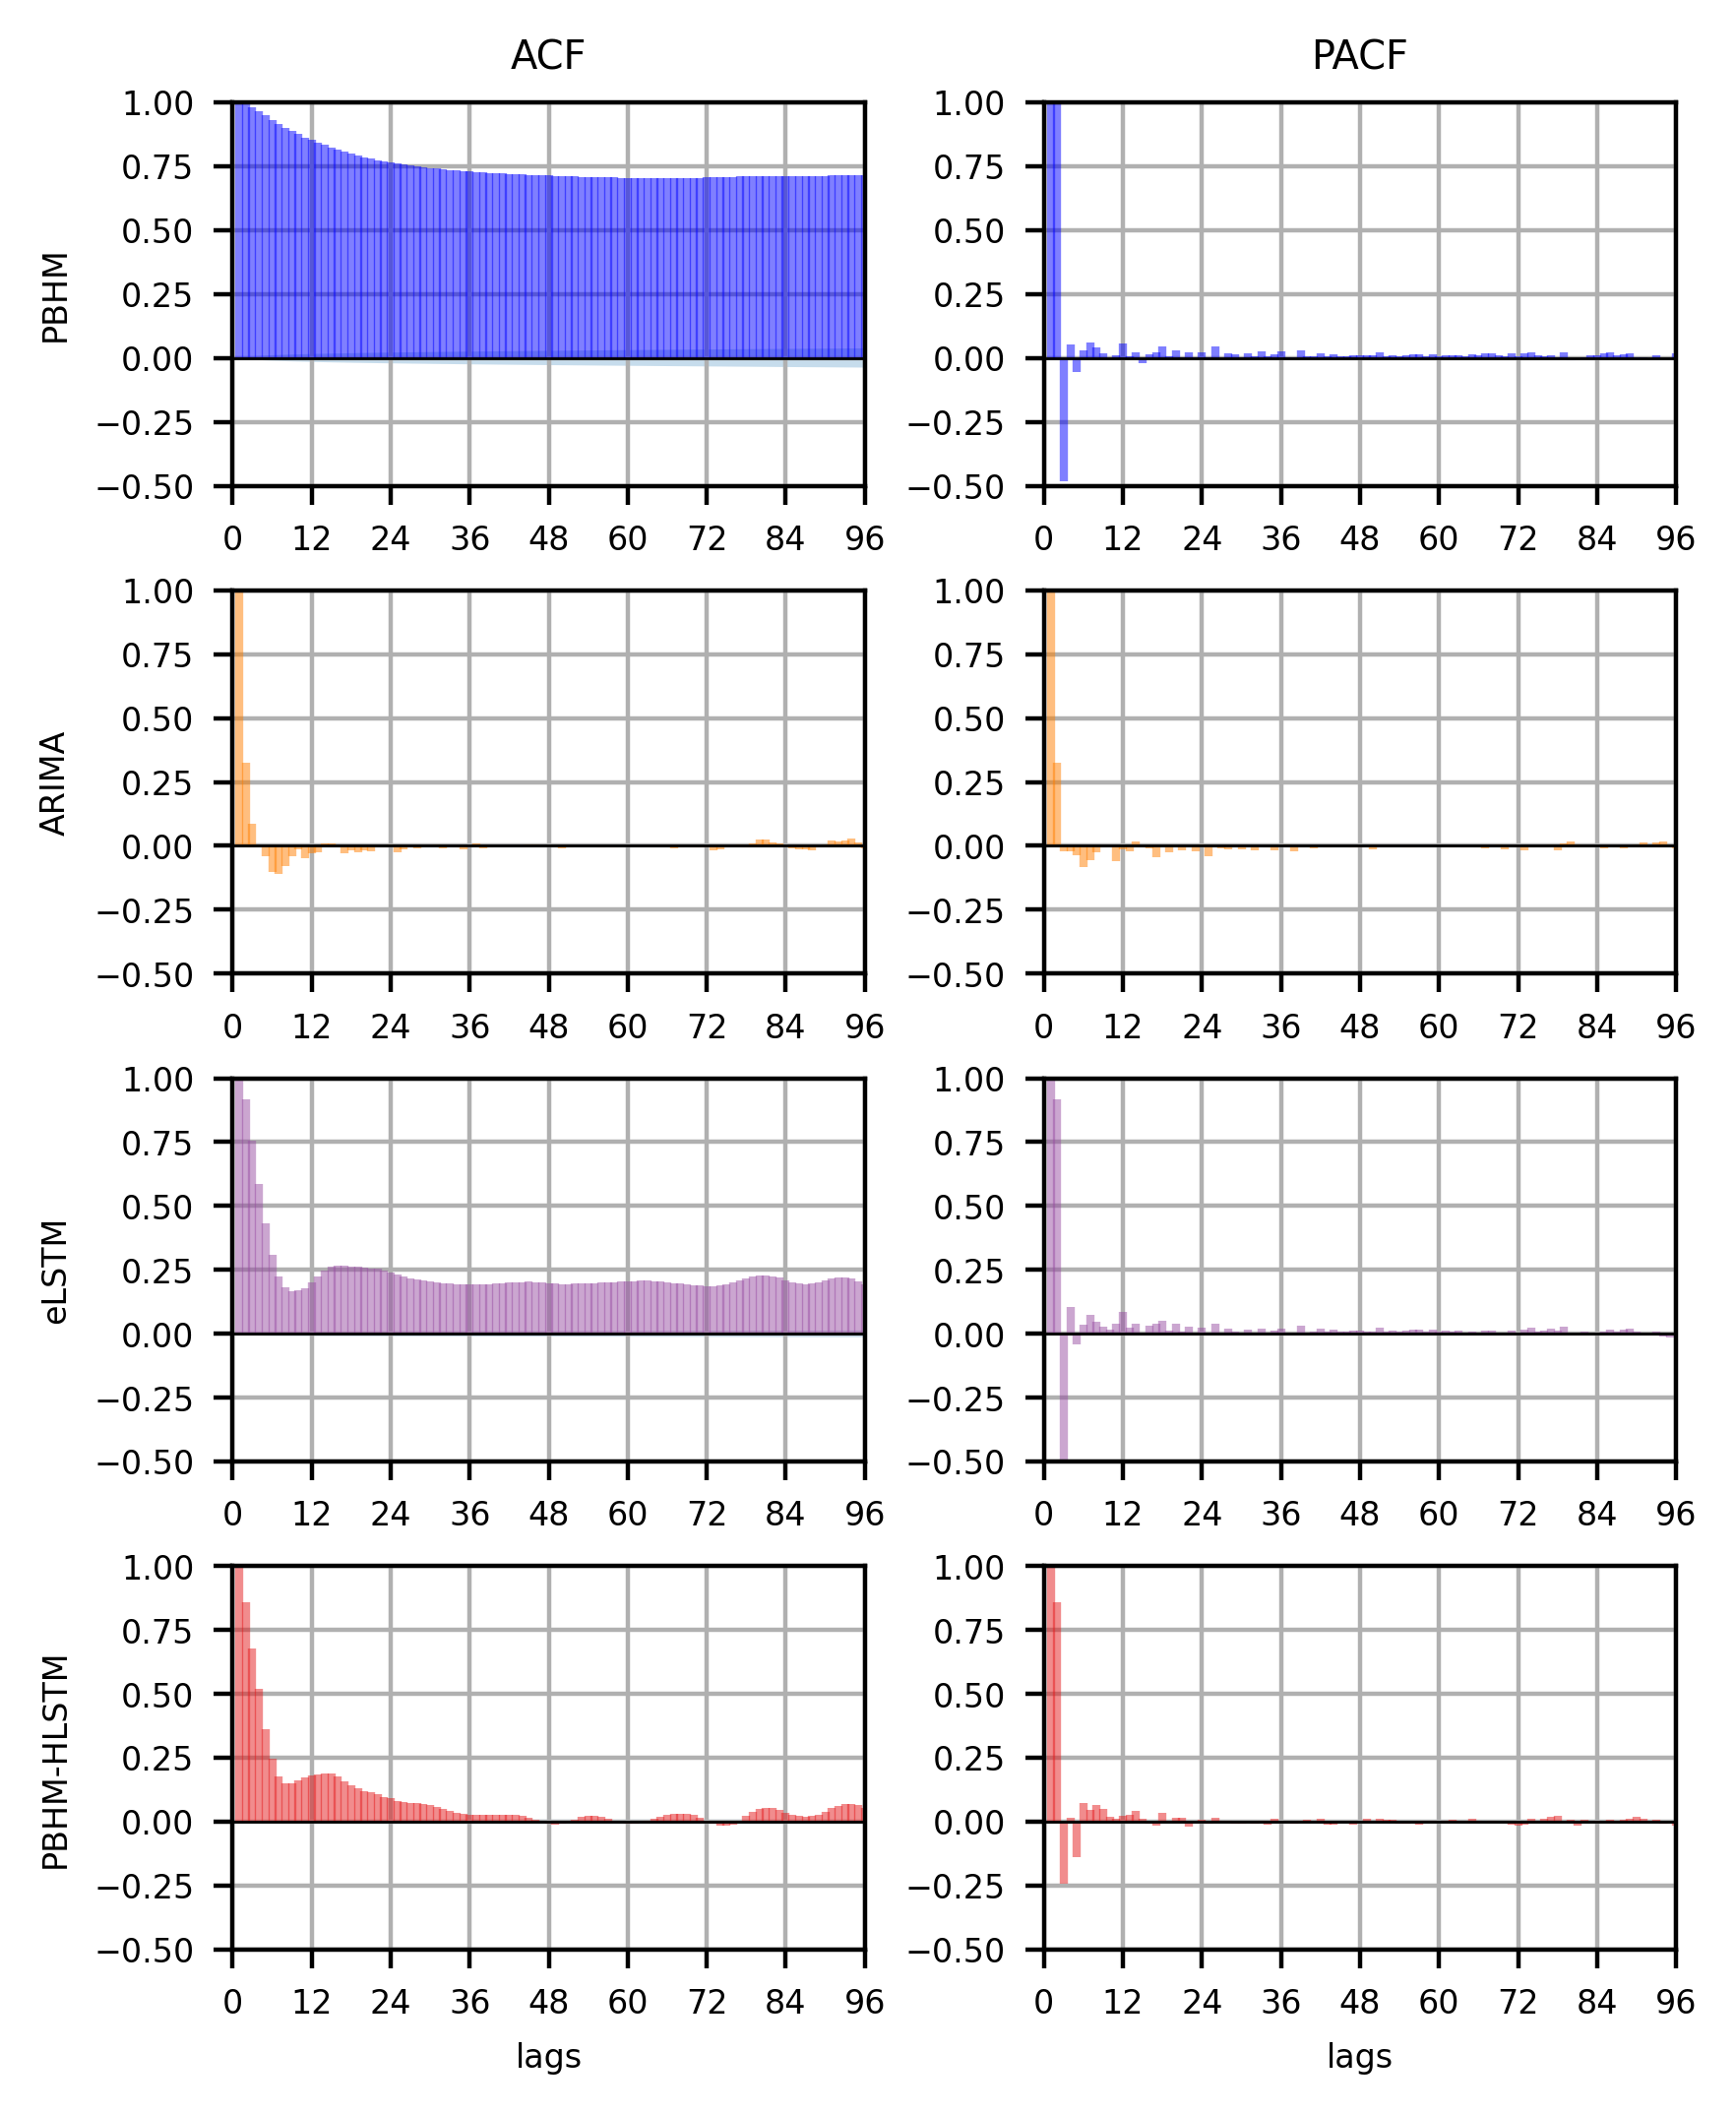

In [152]:
n_lags = 96
df = pd.DataFrame(index=pd.MultiIndex(levels=[[], np.arange(96)], 
                                      codes=[[], []], 
                                      names=["model", "leadtime"],
                                     ),
                  columns = ["corr", "breushpagan_lm", "breushpagan_fvalue"],
             )

fig, axes = plt.subplots(4,2,figsize=(4.72,6), dpi=400)
for n, key in enumerate(models.keys()):
    print(key)

    if models[key].is_external_model:
        overlap_length = 0
        hindcast_length = 96
    else:
        # load datamodel
        dm = DataModelCV(DATA_PATH,
           target_name       = models[key].target_name,
           hincast_features  = models[key].feat_hindcast,
           forecast_features = models[key].feat_forecast,
         )
        
        # load trial data
        with open(os.path.join(models[key].hp_path, "trial.json")) as f:
            trial = json.load(f)

        hindcast_length = trial['hyperparameters']['values']['hindcast_length']
        try:
            overlap_length = trial['hyperparameters']['values']['osc_length']
        except:
            overlap_length = 0 
        
        dm.main(os.path.join(CROSS_INDICES_PATH, f"cross_indices_{hindcast_length}.pkl"))

    n_fold = 4 # evaluate year 2017
    year = 2013 + n_fold
    print(year)
    if models[key].is_external_model:
        # load external which come already with observations
        ext_df = pd.read_pickle(os.path.join(models[key].hp_path, f"forecast_{year}.pkl"))

        # get external model observations
        y = np.expand_dims(ext_df.filter(like="obs").values, axis=2) # fix 

        # get external model predictions
        yp = ext_df.filter(like="fc").values

        # get hydrologic model data
        ysim = ext_df.filter(like="sim").values
        res_sim = ysim - y[:,:,0]
                    
    else:
        # load dataset
        X, y  = dm.getDataSet(dm.cross_sets[n_fold]["test"], scale=True) 

        if os.path.exists(os.path.join(models[key].hp_path, f"forecast_{year}.pkl")):
            yp = pd.read_pickle(os.path.join(models[key].hp_path, f"forecast_{year}.pkl")).values
        else:
            # load model
            tf.keras.backend.clear_session()
            model  = tf.keras.models.load_model(os.path.join(models[key].hp_path, f"model_fold_{n_fold:d}.keras"))                          

            # model prediction
            yp = model.predict(X, batch_size=1000)
            
    # calc residuals       
    res = yp - y[:,:,0]

    # plot pbhm acf and pacfs
    if n == 0:
        n_leadtime = 0
        plot_acf(res_sim[:,n_leadtime],  lags=n_lags, bartlett_confint=True,
                ax = axes[n, 0], title="", 
                 linewidth=0.01,
                 markersize=0, 
                 vlines_kwargs={"colors": "b",
                               "alpha"  : 0.5,
                              },  
                 alpha=0.5)
        plot_pacf(res_sim[:,n_leadtime], lags=n_lags,
                ax = axes[n, 1], title="", method="ywadjusted", 
                  linewidth=0.01, 
                  markersize=0, 
                 vlines_kwargs={"colors": "b",
                               "alpha"  : 0.5,
                              }, 
                  alpha=0.5)
        axes[n, 0].set_ylabel("PBHM")

        for lts in range(96):
            exog = np.append(np.ones_like(y[:,lts]), y[:,lts], axis=1)
            df.loc[("pbhm", lts), :] = [  np.corrcoef(ysim[:,lts], y[:,lts,0])[0,1],
                                    het_breuschpagan(res_sim[:,lts], exog)[0],
                                    het_breuschpagan(res_sim[:,lts], exog)[2], 
                                 ]
    
    for lts in range(96):
        exog = np.append(np.ones_like(y[:,lts]), y[:,lts], axis=1)
        df.loc[(key, lts), :] = [  np.corrcoef(yp[:,lts], y[:,lts,0])[0,1],
                                het_breuschpagan(res[:,lts], exog)[0],
                                het_breuschpagan(res[:,lts], exog)[2], 
                             ]

    n +=1
    n_leadtime = 0
    plot_acf(res[:,n_leadtime],  lags=n_lags, bartlett_confint=True,
            ax = axes[n, 0], title="", 
             linewidth=0.01, 
             markersize=0,
             vlines_kwargs={"colors": models[key].color,
                           "alpha"  : 0.5,
                          }, 
             alpha=0.5)
    plot_pacf(res[:,n_leadtime], lags=n_lags,
            ax = axes[n, 1], title="", method="ywadjusted", 
              linewidth=0.01, 
              markersize=0, 
              vlines_kwargs={"colors": models[key].color,
                           "alpha"  : 0.5,
                          }, 
              alpha=0.5)
    
    axes[n, 0].set_ylabel(models[key].name)

for n in range(4):
    axes[n, 0].set_xlim((-1,95))
    axes[n, 1].set_xlim((-1,95))
    axes[n, 0].set_ylim((-0.5,1))
    axes[n, 1].set_ylim((-0.5,1))
    axes[n, 0].grid()
    axes[n, 1].grid()

    axes[n, 0].axhline(0, color="k", lw=0.5)
    axes[n, 1].axhline(0, color="k", lw=0.5)
    
    axes[n, 0].xaxis.set_major_locator(FixedLocator(np.arange(-1,97,12)))
    axes[n, 1].xaxis.set_major_locator(FixedLocator(np.arange(-1,97,12)))
    axes[n, 0].yaxis.set_major_locator(FixedLocator(np.arange(-0.5,1.1,0.25)))
    axes[n, 1].yaxis.set_major_locator(FixedLocator(np.arange(-0.5,1.1,0.25)))

    axes[n, 0].set_xticklabels([f"{x+1:d}" for x in axes[n, 0].get_xticks()])
    axes[n, 1].set_xticklabels([f"{x+1:d}" for x in axes[n, 1].get_xticks()])

    if n == 0:
        axes[n, 0].set_title("ACF")
        axes[n, 1].set_title("PACF")
    if n == 3:
        axes[n, 0].set_xlabel("lags")
        axes[n, 1].set_xlabel("lags")
    
fig.tight_layout()
plt.subplots_adjust(top=0.85, right=0.9)

In [146]:
fig.savefig(os.path.join(PLOT_PATH, f'figX_acf_pacf-2017.png'), dpi=300, bbox_inches='tight')

Text(0.5, 0, 'leadtime')

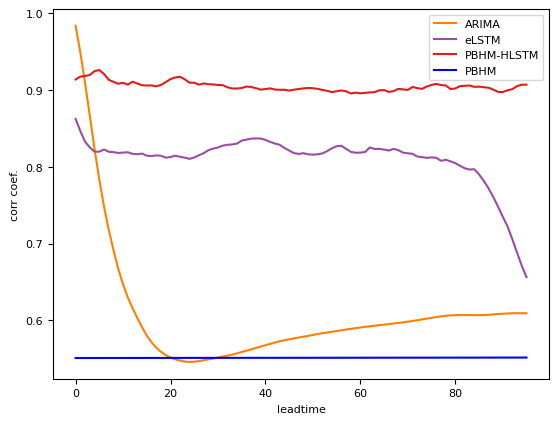

In [129]:
# correlation of predictions and observations
fig, ax = plt.subplots(1,1)
for key in models.keys():
    plt.plot(df.xs(key, level=0)["corr"], color=models[key].color, label=models[key].name)
plt.plot(df.xs("pbhm", level=0)["corr"], color="b", label="PBHM")
plt.legend()
plt.ylabel("corr coef.")
plt.xlabel("leadtime")

In [130]:
fig.savefig(os.path.join(PLOT_PATH, f'corr_2017.png'), dpi=300, bbox_inches='tight')

Text(0.5, 0, 'leadtime')

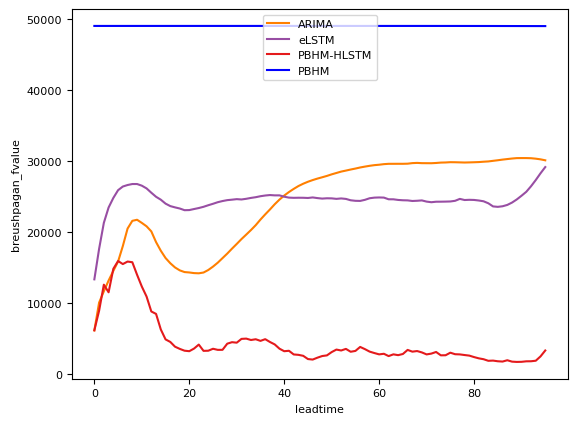

In [131]:
# the larger F the smaller p for H0 to be true, i.e. homoscedasticity in residuals
fig, ax = plt.subplots(1,1)
for key in models.keys():
    plt.plot(df.xs(key, level=0)["breushpagan_fvalue"], color=models[key].color, label=models[key].name)
plt.plot(df.xs("pbhm", level=0)["breushpagan_fvalue"], color="b", label="PBHM")
plt.legend(loc="upper center")
plt.ylabel("breushpagan_fvalue")
plt.xlabel("leadtime")

In [132]:
fig.savefig(os.path.join(PLOT_PATH, f'breushpagan_2017.png'), dpi=300, bbox_inches='tight')